In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from keras.layers import Dropout
from keras.models import load_model

In [2]:
data = pd.read_excel('data/shepard_energy_consumption.xlsx')
data.rename(columns={'CUNY City College of New York - 2018-09-01 -> 2023-08-31': 'Timestamp'}, inplace=True)
data.drop(data.index[0], inplace=True)
data.rename(columns={'12785711': 'Meter1'}, inplace=True)
data.rename(columns={'12785712': 'Meter2'}, inplace=True)



In [3]:
data.head()

,Timestamp,Meter1,Meter2
1,2018-09-01 01:00:00,124,217.5
2,2018-09-01 02:00:00,124,218
3,2018-09-01 03:00:00,126,216.5
4,2018-09-01 04:00:00,124,216
5,2018-09-01 05:00:00,122.5,219


In [4]:
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data.set_index('Timestamp', inplace=True)



In [5]:
data.head()

,Meter1,Meter2
Timestamp,,
2018-09-01 01:00:00,124,217.5
2018-09-01 02:00:00,124,218
2018-09-01 03:00:00,126,216.5
2018-09-01 04:00:00,124,216
2018-09-01 05:00:00,122.5,219


In [6]:
# Nomalize data for meter1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Meter1'].values.reshape(-1, 1))

In [7]:
print(scaled_data[0:25])
scaled_data[24]

[[0.55555556]
 [0.55555556]
 [0.56790123]
 [0.55555556]
 [0.5462963 ]
 [0.54938272]
 [0.53395062]
 [0.54012346]
 [0.5462963 ]
 [0.55246914]
 [0.54320988]
 [0.54012346]
 [0.54012346]
 [0.54012346]
 [0.54320988]
 [0.54012346]
 [0.54938272]
 [0.58333333]
 [0.57407407]
 [0.57098765]
 [0.57407407]
 [0.57716049]
 [0.56790123]
 [0.5617284 ]
 [0.55864198]]


array([0.55864198])

In [8]:
# Function to create dataset for LSTM
# stores values in array X that will be used to predict value in correspending index in Y
# first iteration
# 0-23 values stored in X, 24th value stored in Y(target value)
# second iteration 
# 1-24 stored in X, 25th value stored in Y
def create_dataset(dataset, look_back=48):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1): #ensures that loop stops at a point where there is enough datapoints for a last X, and Y set
        a = dataset[i:(i + look_back), 0]  #slices values in dataset from i to i+24
        X.append(a)
        Y.append(dataset[i + look_back, 0]) # stores the value right after a into Y
    return np.array(X), np.array(Y)

In [9]:
# Creating the dataset suitable for LSTM
X, Y = create_dataset(scaled_data)

In [10]:
print(X[0])
print(Y[0])

[0.55555556 0.55555556 0.56790123 0.55555556 0.5462963  0.54938272
 0.53395062 0.54012346 0.5462963  0.55246914 0.54320988 0.54012346
 0.54012346 0.54012346 0.54320988 0.54012346 0.54938272 0.58333333
 0.57407407 0.57098765 0.57407407 0.57716049 0.56790123 0.5617284
 0.55864198 0.55864198 0.55246914 0.55246914 0.54938272 0.54938272
 0.53395062 0.53703704 0.54320988 0.53703704 0.54012346 0.5462963
 0.5462963  0.54938272 0.5462963  0.54012346 0.54938272 0.56790123
 0.55864198 0.56790123 0.57716049 0.57407407 0.57407407 0.56790123]
0.5617283950617284


In [11]:
print(X.shape[1])


48


In [12]:


# Reshaping input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Splitting the dataset into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

In [13]:
X.shape

(43775, 48, 1)

In [14]:

# Building the LSTM network
## sequential model means layers are a linear stack where layers can be added one after another 
model = Sequential()
## first layer has 50 neurons, inpputshape(time steps, features) return_sequences because there is another layer
model.add(LSTM(50, input_shape=(X_train.shape[1], 1), return_sequences=True))
model.add(Dropout(0.2))
# second and last layer 
model.add(LSTM(50, return_sequences= True))
model.add(Dropout(0.2))
model.add(LSTM(50))
# output for final predictin Dense means the neuron is fully connected with previous neurons
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 48, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 48, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 48, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 48, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 

In [16]:
# Training the model
model.fit(X_train, Y_train, epochs=10, batch_size=64, verbose=1)
#model starts processing data in X_train and amkes predictions for y_train adjusts every epoch based on MSE thus training it 

Epoch 1/10
548/548 [==============================] - 63s 103ms/step - loss: 0.0046
Epoch 2/10
548/548 [==============================] - 55s 100ms/step - loss: 0.0016
Epoch 3/10
548/548 [==============================] - 55s 101ms/step - loss: 0.0012
Epoch 4/10
548/548 [==============================] - 56s 102ms/step - loss: 9.0188e-04
Epoch 5/10
548/548 [==============================] - 61s 111ms/step - loss: 7.3598e-04
Epoch 6/10
548/548 [==============================] - 55s 101ms/step - loss: 6.4387e-04
Epoch 7/10
548/548 [==============================] - 59s 108ms/step - loss: 5.7406e-04
Epoch 8/10
548/548 [==============================] - 61s 112ms/step - loss: 5.4546e-04
Epoch 9/10
548/548 [==============================] - 70s 128ms/step - loss: 5.5291e-04
Epoch 10/10
548/548 [==============================] - 65s 119ms/step - loss: 5.3274e-04


In [18]:
model.save('10_epoch.h5')

c:\Users\jubya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
train_predict = model.predict(X_train)
# model makes prediction for energy output based on previously seen data
#train_predict should predict the valyes in Y_train
test_predict = model.predict(X_test)
# model makes predictions based of new data
# test_predict should predict the valyes in Y_test

274/274 [==============================] - 7s 24ms/step


In [20]:

# Inverting predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
Y_train_inv = scaler.inverse_transform([Y_train])
Y_test_inv = scaler.inverse_transform([Y_test])

In [21]:
Y_train_inv.shape
print(Y_train_inv[0])


[125.  123.  122.5 ... 104.5 105.  102. ]


In [22]:
# Calculating RMSE
train_rmse = np.sqrt(mean_squared_error(Y_train_inv[0], train_predict[:,0]))
test_rmse = np.sqrt(mean_squared_error(Y_test_inv[0], test_predict[:,0]))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

Train RMSE: 3.305829038284914
Test RMSE: 3.985442663738535


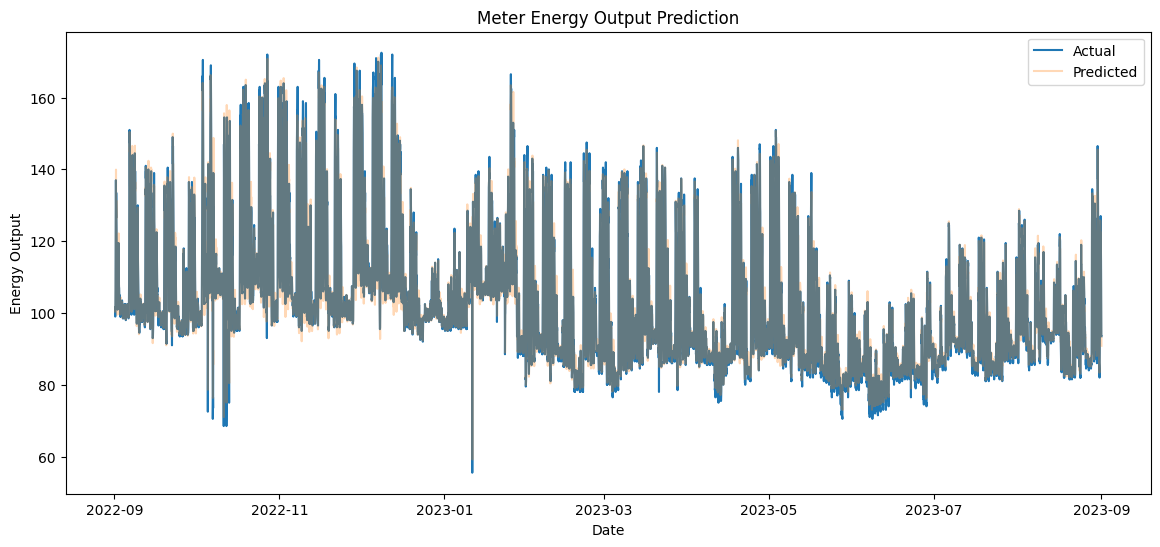

In [49]:
# Plotting the results
plt.figure(figsize=(14, 6))
plt.plot(data['Meter1'][-len(Y_test):].index, Y_test_inv[0], label='Actual')
plt.plot(data['Meter1'][-len(Y_test):].index, test_predict[:, 0], label='Predicted', alpha = 0.3)
plt.title('Meter Energy Output Prediction')
plt.xlabel('Date')
plt.ylabel('Energy Output')
plt.legend()
plt.show()

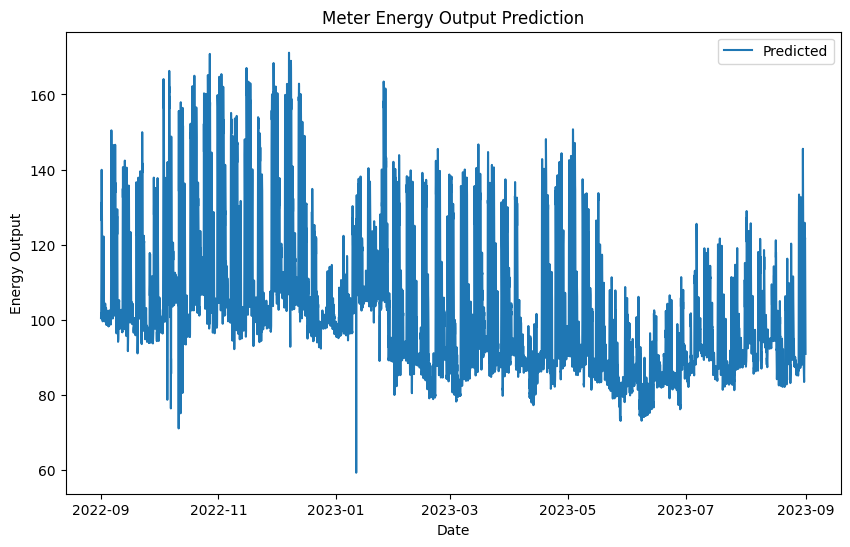

In [25]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(data['Meter1'][-len(Y_test):].index, test_predict[:, 0], label='Predicted')
plt.title('Meter Energy Output Prediction')
plt.xlabel('Date')
plt.ylabel('Energy Output')
plt.legend()
plt.show()

In [27]:
recent_data_week = data['Meter1'][-24:]
scaled_recent_data_week = scaler.transform(recent_data_week.values.reshape(-1,1))
print(scaled_recent_data_week)

[[0.32098765]
 [0.31790123]
 [0.3117284 ]
 [0.30864198]
 [0.29938272]
 [0.2962963 ]
 [0.30246914]
 [0.32716049]
 [0.36111111]
 [0.4845679 ]
 [0.53395062]
 [0.54938272]
 [0.5308642 ]
 [0.55555556]
 [0.5617284 ]
 [0.57407407]
 [0.54938272]
 [0.53703704]
 [0.5       ]
 [0.44135802]
 [0.40123457]
 [0.36728395]
 [0.36728395]
 [0.36419753]]


In [28]:
print(len(recent_data_week))

24


In [29]:
sequence_week = np.reshape(scaled_recent_data_week, (1, 24, 1))
predictions_week = []

In [1]:
print(sequence_week)

NameError: name 'sequence_week' is not defined

In [30]:
for i in range(7*24):  # Loop for 7 days 24 hours a day 
    daily_prediction_scaled = model.predict(sequence_week)
    daily_prediction = scaler.inverse_transform(daily_prediction_scaled)
    predictions_week.append(daily_prediction[0, 0])
    
    # Update the sequence: roll and append the new prediction
    sequence_week = np.roll(sequence_week, -1)
    sequence_week[0, -1, 0] = daily_prediction_scaled[0, 0]

1/1 [==============================] - 0s 30ms/step


In [31]:
print(len(predictions_week))
print(predictions_week)


168
[92.310074, 91.78914, 91.05098, 90.15921, 89.60212, 90.15865, 92.52437, 96.880424, 102.69262, 108.9616, 114.71414, 119.383316, 122.70426, 124.57779, 125.00451, 124.04376, 121.824615, 118.56055, 114.56325, 110.22713, 105.97922, 102.19154, 99.105576, 96.78088, 95.12229, 93.9547, 93.13476, 92.66698, 92.76658, 93.81133, 96.16306, 99.93255, 104.84138, 110.28762, 115.56586, 120.08791, 123.48502, 125.58344, 126.33204, 125.75509, 123.94386, 121.06869, 117.39171, 113.262276, 109.07805, 105.21293, 101.937004, 99.36571, 97.46208, 96.09499, 95.13757, 94.5743, 94.56985, 95.44687, 97.54832, 101.0325, 105.72006, 111.099525, 116.49223, 121.26956, 124.9949, 127.438576, 128.51668, 128.23398, 126.66374, 123.95438, 120.34437, 116.166275, 111.819466, 107.70378, 104.13397, 101.27357, 99.11997, 97.55026, 96.41647, 95.66153, 95.41004, 95.97645, 97.75029, 100.98531, 105.60434, 111.14906, 116.91499, 122.187874, 126.43676, 129.36848, 130.86925, 130.92946, 129.60843, 127.03599, 123.43029, 119.112305, 114.4922

In [32]:
# Start and end dates
start_date = pd.to_datetime('2023-09-01 01:00')
end_date = pd.to_datetime('2023-09-08 00:00')  

# Generate a list of hourly timestamps
timestamps = pd.date_range(start=start_date, end=end_date, freq='H')

In [33]:
print(len(timestamps))
print(len(predictions_week))


168
168


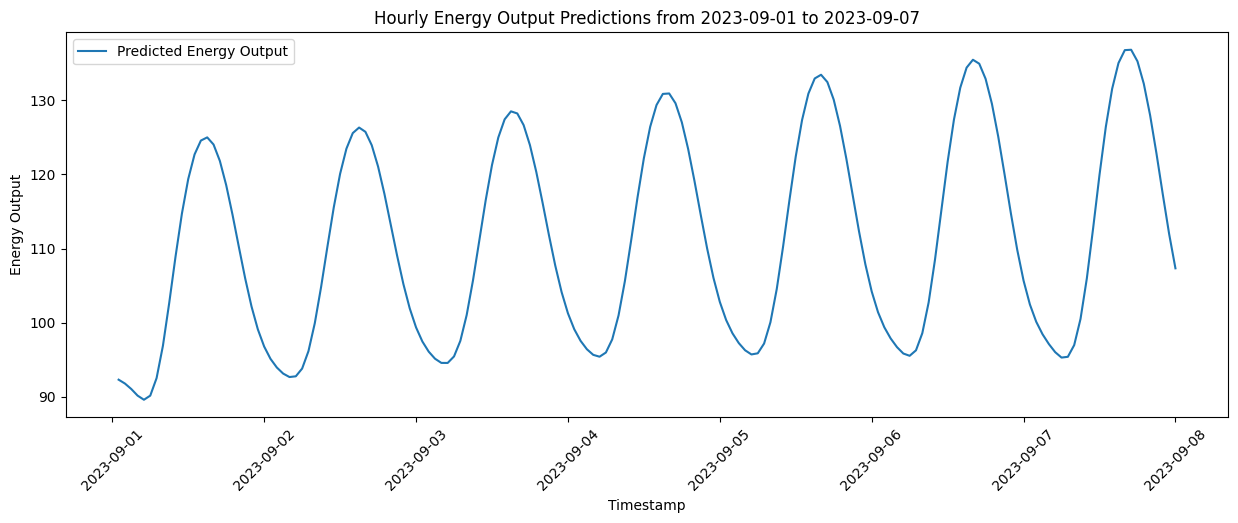

In [34]:
plt.figure(figsize=(15, 5)) 
plt.plot(timestamps, predictions_week, label='Predicted Energy Output')
plt.xlabel('Timestamp')
plt.ylabel('Energy Output')
plt.title('Hourly Energy Output Predictions from 2023-09-01 to 2023-09-07')
plt.xticks(rotation=45)  
plt.legend()
plt.show()

In [39]:
print(predictions_week[0:10])

[92.310074, 91.78914, 91.05098, 90.15921, 89.60212, 90.15865, 92.52437, 96.880424, 102.69262, 108.9616]


In [40]:
recent_data_month = data['Meter1'][-24:]
scaled_recent_data_month = scaler.transform(recent_data_month.values.reshape(-1,1))
sequence_month = np.reshape(scaled_recent_data_month, (1,24,1))
print(scaled_recent_data_month)

[[0.32098765]
 [0.31790123]
 [0.3117284 ]
 [0.30864198]
 [0.29938272]
 [0.2962963 ]
 [0.30246914]
 [0.32716049]
 [0.36111111]
 [0.4845679 ]
 [0.53395062]
 [0.54938272]
 [0.5308642 ]
 [0.55555556]
 [0.5617284 ]
 [0.57407407]
 [0.54938272]
 [0.53703704]
 [0.5       ]
 [0.44135802]
 [0.40123457]
 [0.36728395]
 [0.36728395]
 [0.36419753]]


In [41]:
predictions_month = []
for i in range(30 * 24):  # 30 days * 24 hours
    hourly_prediction_scaled = model.predict(sequence_month)
    hourly_prediction = scaler.inverse_transform(hourly_prediction_scaled)
    predictions_month.append(hourly_prediction[0, 0])

    sequence_month = np.roll(sequence_month, -1)
    sequence_month[0, -1, 0] = hourly_prediction_scaled[0, 0]


1/1 [==============================] - 0s 26ms/step


In [42]:
start_date_month = pd.to_datetime('2023-09-01 00:00')
end_date_month = pd.to_datetime('2023-09-30 23:00')
timestamps_month = pd.date_range(start=start_date_month, end=end_date_month, freq='H')


In [43]:
print(len(timestamps_month))
print(len(predictions_month))


720
720


In [42]:
print(predictions_month)

[89.10041, 88.647, 88.96858, 90.10748, 92.02352, 94.63485, 97.79427, 101.30348, 104.9107, 108.35264, 111.255394, 113.50036, 114.96321, 115.603615, 115.37799, 114.39475, 112.784874, 110.75884, 108.48532, 106.16783, 103.98843, 102.06418, 100.498215, 99.33214, 98.61766, 98.399605, 98.65052, 99.33879, 100.4073, 101.776566, 103.34842, 105.01188, 106.65068, 108.15254, 109.41857, 110.3729, 110.96732, 111.18513, 111.04042, 110.57489, 109.85096, 108.94451, 107.93699, 106.90906, 105.93478, 105.07786, 104.389244, 103.90543, 103.64819, 103.62411, 103.82504, 104.22943, 104.803764, 105.50481, 106.28252, 107.08351, 107.85477, 108.54766, 109.121445, 109.54613, 109.80436, 109.89207, 109.81797, 109.60189, 109.272385, 108.86378, 108.41331, 107.95806, 107.532646, 107.16708, 106.88532, 106.704216, 106.63298, 106.67321, 106.8191, 107.058235, 107.37267, 107.74032, 108.13652, 108.53592, 108.91416, 109.24965, 109.52493, 109.72772, 109.8517, 109.89636, 109.86695, 109.77348, 109.62979, 109.45228, 109.258484, 109

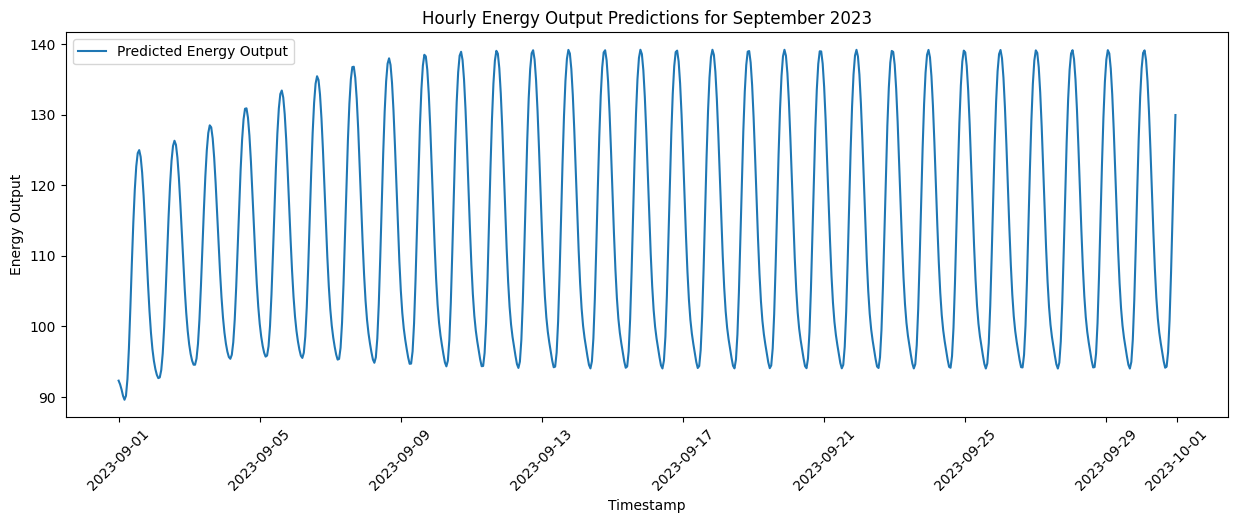

In [44]:
plt.figure(figsize=(15, 5))
plt.plot(timestamps_month, predictions_month, label='Predicted Energy Output')
plt.xlabel('Timestamp')
plt.ylabel('Energy Output')
plt.title('Hourly Energy Output Predictions for September 2023')
plt.xticks(rotation=45)
plt.legend()
plt.show()


In [36]:
import csv

In [38]:
with open('week_predictions.csv', 'w', newline='')as file:
    writer = csv.writer(file)
    for prediction in predictions_week:
        writer.writerow([prediction])